In [4]:
%matplotlib inline
from tqdm import tqdm
import random
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import os
import torchaudio
from torchaudio.transforms import MelSpectrogram
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
cudnn.benchmark = True
plt.ion()   # interactive mode
from tsne import tsne

N_SAMPLES=25500 #fixed length
label_list=['808s','Claps','Closed Hats','Crashes & Cymbals','Extras','FX','Kicks','Open Hats','Percs','Snares','Vox']
data_dir= './data'


paths=[]
labels=[]
for root, subdirs, files in os.walk(data_dir):
    if len(files)>0:
        label=os.path.basename(os.path.normpath(root))
        if label in label_list:
            for file in files:
                if (file[-3:]=='wav' or file[-3:]=='WAV') and file[0]!='.' and  os.path.getsize(os.path.join(root, file)) >1024*10:
                    labels.append(label)
                    paths.append(os.path.join(root, file))

c = list(zip(paths, labels))
random.Random(42).shuffle(c)
paths, labels = zip(*c)

val_paths=paths[:len(paths)//10]
val_labels=labels[:len(paths)//10]

train_paths=paths[len(paths)//10:]
train_labels=labels[len(paths)//10:]
print(len(train_paths),len(val_paths))

class AudioDataset(Dataset):
    
    def __init__(self, mypaths, mylabels,transform=None):
        self.paths=mypaths
        self.labels=mylabels
        self.n_samples=len(mypaths)
        self.label_list=label_list
    def __getitem__(self, index):
        waveform, sample_rate = torchaudio.load(self.paths[index], normalize=True)
        waveform = torch.mean(waveform, dim=0).unsqueeze(0) #mono
        #
        # to fixed length
        target = torch.zeros(1, N_SAMPLES)
        target[:,:min(waveform.shape[1],N_SAMPLES) ] = waveform[:,:min(waveform.shape[1],N_SAMPLES)]
        waveform=target
        
        #mel, expand for resnet to 3 channels
        mel = MelSpectrogram(sample_rate)(waveform)

        return  mel.expand(3,-1,-1), torch.tensor(self.label_list.index(self.labels[index]))

   
    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
    

4838 537


In [5]:
audio_datasets = {'train': AudioDataset(train_paths,train_labels),'val': AudioDataset(val_paths,val_labels)}
class_names = label_list
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
#load model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names)) #classes

model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load('./resnet18'))
model_ft.eval()
from torchsummary import summary
summary(model_ft, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

C:\Users\nguye\anaconda3\envs\envDL\lib\site-packages\torchaudio\functional\functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


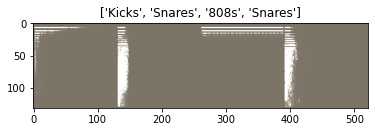

In [8]:
tmp = {x: torch.utils.data.DataLoader(audio_datasets[x], batch_size=4,shuffle=True, num_workers=0) for x in ['train', 'val']}
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(tmp['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
dataloaders = {x: torch.utils.data.DataLoader(audio_datasets[x], batch_size=4,
                                             shuffle=False, num_workers=0)
              for x in ['train', 'val']}
N_POINTS=4000
def get_X(model, num_samples=1000):
    X=[]
    Y=[]
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in tqdm(enumerate(dataloaders['train']),position=0,leave=True):
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                #print(outputs[j].shape)
                X.append(outputs[j].cpu().numpy())
                Y.append(labels[j].cpu().numpy())
                if images_so_far ==num_samples:
                    
                    model.train(mode=was_training)
                    return np.array(X),np.array(Y)
        
X,labels=get_X(model_ft,num_samples=N_POINTS)
assert([label_list.index(i) for i in train_labels[:N_POINTS]]==labels).all()

999it [00:20, 48.51it/s]


<Figure size 432x288 with 0 Axes>

C:\Users\nguye\Documents\GitHub\audio-sample-explorer\tsne.py:16: RuntimeWarning: invalid value encountered in true_divide
  P = P / np.sum(P)


0.979436234129656
The 100 th loop cost: 16.90012519058155, computation time: 56.15080428123474
The 200 th loop cost: 1.7138579727394392, computation time: 114.3334641456604
The 300 th loop cost: 1.1796722920257066, computation time: 174.3064365386963
The 400 th loop cost: 0.9675984571056806, computation time: 232.57361030578613
The 500 th loop cost: 0.8805702920624487, computation time: 291.0043132305145
The 600 th loop cost: 0.8317894425931605, computation time: 355.63910007476807
The 700 th loop cost: 0.8007029657579289, computation time: 418.8176305294037
The 800 th loop cost: 0.7792689690354543, computation time: 482.6047697067261
The 900 th loop cost: 0.7635675170320474, computation time: 545.7682988643646
The 1000 th loop cost: 0.7510923294687482, computation time: 608.4947519302368


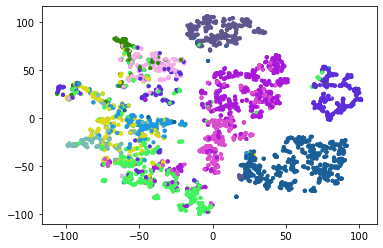

In [22]:
from tsne import tsne

Y = tsne(X, low_dim=2, perplexity=15.0)

colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1],10,color_labels)
plt.show()

In [24]:
import pandas as pd

df = pd.DataFrame()
df['x']=Y[:,0]
df['y']=Y[:,1]
df['label_num']=labels
df['label_name']=train_labels[:N_POINTS]
df['path']=train_paths[:N_POINTS]
df.to_csv('./tsne_data_3D.csv')